### Проект: вариант 4

### Задание 1
   Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). 
   Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. 

#### Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

### Задание 2
Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

# Задание 1

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
active_users = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-demchenko-18/Final_Project/Проект_4_active_users.csv')

In [3]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-demchenko-18/Final_Project/Проект_4_groups.csv')

In [4]:
purchases = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-demchenko-18/Final_Project/Проект_4_purchases.csv')

In [5]:
# Проверим df на наличие пропущенных значений

In [6]:
active_users.isna().sum()

user_id     0
country     0
platform    0
sex         0
dtype: int64

In [7]:
purchases.isna().sum()

user_id    0
revenue    0
dtype: int64

In [8]:
groups.isna().sum()

user_id    0
group      0
dtype: int64

In [9]:
# Пропущенных значений в датафреймах нет. Теперь посмотрим на соотношения уникальных пользователей

In [10]:
# Кол-во уникальных активных пользователей во время проведения эксперимента (user_id)
active_users.user_id.nunique()

8341

In [11]:
# Кол-во пользователей в тестовой(В) и контрольной(А) группах
groups.group.value_counts()

B    59883
A    14693
Name: group, dtype: int64

In [12]:
# Общее число пользователей, принимавших участие в эксперименте
groups.user_id.nunique()

74576

Из 74576 уникальных пользователей, учавствующих в тестировании (из них в тестовой группе - 59883, контрольной - 14693), кол-во пользователей, посетивших приложение составило 8341.

Соединим датафрейм groups с датафреймом active_users, оставив только активных пользователей, посетивших приложение во время эксперимента. Для этого воспользуемся методом соединения строк "inner" с фильтром по "user_id"

In [13]:
df = groups.merge(active_users, on="user_id", how="inner")

In [14]:
# Проверим , что кол-во активнх пользователей из датафрейма active_users (8341) не изменилось
df.user_id.nunique()

8341

Соединим получившийся датафрейм с информацией о пользователях, совершивших транзакции, методом соединения строк "left" (чтобы оставить информацию о пользователях не совершивших транзакции) с фильтром "user_id"

In [15]:
df_full = df.merge(purchases, on="user_id", how="left")

In [16]:
df_full.isna().sum()

user_id        0
group          0
country        0
platform       0
sex            0
revenue     7949
dtype: int64

In [17]:
# Проверка на дубликаты
any(df_full['user_id'].duplicated())

False

In [18]:
# Проверим , что кол-во активных пользователей (8341) не изменилось
df_full.user_id.nunique()

8341

In [19]:
# Проверим кол-во пользователей в тестовой и контрольной группах
df_full.groupby('group').agg({'user_id':'count'})

,user_id
group,
A,1538
B,6803


In [20]:
# Посмотрим какое кол-во из всех пользователей в контрольной и тестовой группах совершили целевое действие

In [22]:
df_full.query("group == 'A'").revenue.count()

78

In [23]:
df_full.query("group == 'B'").revenue.count()

314

В контрольной группе число пользователей, купивших шаблоны, составило 78 человек, в тестовой 314.
Выборки имеют сильный дисбаланс. Так, в тестовой группе людей в 4 раза больше. Посмотрим подробнее как разбиты пользователи на тестовую и контрольную группы.

In [24]:
# Распределение покупателей по группам и по странам
distribution_by_country = (
                df_full
                    .groupby(['group', 'country'], as_index=False)
                    .agg({'user_id': 'count'})
                    .pivot(index='group', columns='country', values='user_id')
                           )

In [25]:
# Распределение покупателей по группам и по платформе
distribution_by_platform = (
                df_full
                    .groupby(['group', 'platform'], as_index=False)
                    .agg({'user_id': 'count'})
                    .pivot(index='group', columns='platform', values='user_id')
                           )

In [26]:
# Распределение покупателей по группам и по полу
distribution_by_sex = (
                df_full
                    .groupby(['group', 'sex'], as_index=False)
                    .agg({'user_id': 'count'})
                    .pivot(index='group', columns='sex', values='user_id')
                      )

In [27]:
# Объединим полученные таблицы
distribution_by_group = pd.concat([distribution_by_country, distribution_by_platform, distribution_by_sex], axis=1).transpose()
distribution_by_group

group,A,B
Russia,915,4492
Sweden,623,2311
android,834,3787
ios,704,3016
female,753,3392
male,785,3411


In [28]:
# Добавим новую колонку с оношением пользователей в тестовой и контрольной группе
distribution_by_group['A/B'] = (distribution_by_group.A/distribution_by_group.B).round(2)
distribution_by_group

group,A,B,A/B
Russia,915,4492,0.20
Sweden,623,2311,0.27
android,834,3787,0.22
ios,704,3016,0.23
female,753,3392,0.22
male,785,3411,0.23


#### Самый большой дисбаланс тестовой и контрольной групп в Швеции. Отношение пользователей контрольной к тестовой группе в Швеции равно 0.27. Рассмотрим подробнее как соотносятся кол-во пользователей в разных странах на разных платформах.

In [29]:
# Сгруппируем по группам, странам и платформам пользователей
distribution_by_country_vs_platform = (
df_full
                    .groupby(['group', 'country','platform'], as_index=False)
                    .agg({'user_id': 'count'})
                    #.pivot(index='group', columns='platform', values='revenue')
                           )
distribution_by_country_vs_platform

,group,country,platform,user_id
0,A,Russia,android,510
1,A,Russia,ios,405
2,A,Sweden,android,324
3,A,Sweden,ios,299
4,B,Russia,android,2478
5,B,Russia,ios,2014
6,B,Sweden,android,1309
7,B,Sweden,ios,1002


In [30]:
# Сгруппируем по группам, странам и полу пользователей
distribution_by_country_vs_sex = (
df_full
                    .groupby(['group', 'country','sex'], as_index=False)
                    .agg({'user_id': 'count'})
                    #.pivot(index='group', columns='platform', values='revenue')
                           )
distribution_by_country_vs_sex

,group,country,sex,user_id
0,A,Russia,female,441
1,A,Russia,male,474
2,A,Sweden,female,312
3,A,Sweden,male,311
4,B,Russia,female,2223
5,B,Russia,male,2269
6,B,Sweden,female,1169
7,B,Sweden,male,1142


### Вывод: большой разброс в отношении пользователей тестовой и контрольной групп в Швеции (0.27) обусловлен неравномерным распределением среди групп пользователей по платформе. Так, в Швеции в тестовой группе значительно преобладают пользователи на android. Что нарушает "честность" результатов A/B тестирования. А с учетом, что выборки у нас и так несбалансированы результаты A/B тестирования для Швеции могут дать ложноположительный или ложноотрицательный результат. 
### Принимаю решение разделить оценку результатов a/b тестирования по странам.
* В подсчетах рассматривала именно отношение, а не разницу, пользователей по параметрам, т.к. группы контрольная и тестовая несбалансированы.

Для групп из России есть небольшой дисбаланс в тестовой группе: отношение женщин к мужчинам 0,98. В то время как в контрольной группе это значение равно 0.93. Следует учесть это при оценке результатов.

In [31]:
# Посмотрим какое медианное(среднее не берем,т.к. есть выбросы) значение общего дохода группы принесли с разбивкой по платформе
paying_by_country_vs_platform = (
                            df_full
                                    .groupby(['group', 'country','platform'], as_index=False)
                                    .agg({'revenue': 'median'})
                                  )
paying_by_country_vs_platform

,group,country,platform,revenue
0,A,Russia,android,593.0
1,A,Russia,ios,590.0
2,A,Sweden,android,850.5
3,A,Sweden,ios,499.0
4,B,Russia,android,1540.0
5,B,Russia,ios,999.5
6,B,Sweden,android,1075.5
7,B,Sweden,ios,1909.0


Интересный факт наблюдаем в Швеции в тестовой группе. Пользователей на android в тестовой группе было гораздо больше, чем на ios. Однако, медианное значение дохода на androide в тестовой группе в Швеции значительно ниже, чем в контрольной. Т.е. с выкатыванием новой фичи приложения с колекцией шаблонов на пользователей в Швеции с платформой android доход значительно ниже, чем в контрольной группе на ios. Вопрос в коректной работе новой версии приложения на платформе android в Швеции.




## Тест Левена на равность дисперсий выборок

Но - дисперсии выборок равны

Тест проведем сначала без разбиения по странам, затем с разбиением по странам.

In [32]:
# Удаляем строки с пропцщенными значениями,чтобы оставить только платящих пользователей
df_paying_user = df_full.dropna()

#### Тест Левена для всех стран

In [171]:
stats.levene(df_paying_user.query("group == 'A'").revenue, df_paying_user.query("group == 'B'").revenue, center='median')[1]

0.08020177652122025

#### Проведем тест Левена для выборок только из России

In [172]:
df_paying_user_Russia = df_paying_user.query("country == 'Russia'")

In [173]:
stats.levene(df_paying_user_Russia.query("group == 'A'").revenue, df_paying_user_Russia.query("group == 'B'").revenue, center='median')[1]

0.010182727165030207

#### Проведем тест Левена для выборок только из Швеции

In [174]:
df_paying_user_Sweden = df_paying_user.query("country == 'Sweden'")

In [175]:
stats.levene(df_paying_user_Sweden.query("group == 'A'").revenue, df_paying_user_Sweden.query("group == 'B'").revenue, center='median')[1]

0.7425575873280059

Полученные значения p-value:
     - 0,08 для всех стран
     - 0,01 для России
     - 0,74 для Швеции

В России мы отклоняем нулевую гипотезу(дисперсии выборок не равны, возможно обусловлено выбросами).
В Швеции мы не можем отклонить нулевую гипотезу(дисперсии выборок равны)

## Проверим выборки на нормальность распределения
Построим гистограммы для визуальной оценки

### Общая

In [176]:
ax = df_full.query("group == 'A'").revenue
bx = df_full.query("group == 'B'").revenue

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


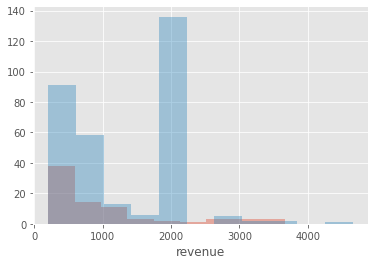

In [177]:
sns.distplot(ax, kde = False)
sns.distplot(bx, kde = False)

Распределения ненормальные. Попробуем прологарифмироать данные

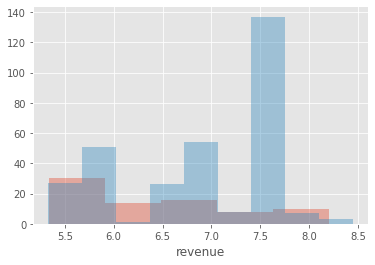

In [178]:
sns.distplot(np.log(ax), kde = False)
sns.distplot(np.log(bx), kde = False)

Логарифмирование не помогло, оставляем как есть.

### Для России

In [179]:
a_Russia = df_full.query("country == 'Russia' and group == 'A'").revenue
b_Russia = df_full.query("country == 'Russia' and group == 'B'").revenue

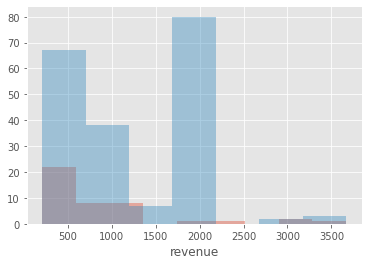

In [180]:
sns.distplot(a_Russia, kde = False)
sns.distplot(b_Russia, kde = False)

### Для Швеции

In [181]:
a_Sweden = df_full.query("country == 'Sweden' & group == 'A'").revenue
b_Sweden = df_full.query("country == 'Sweden' & group == 'B'").revenue

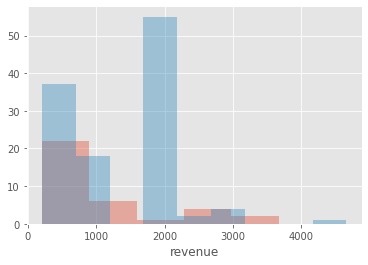

In [182]:
sns.distplot(a_Sweden, kde = False)
sns.distplot(b_Sweden, kde = False)

#### Построим боксплоты

Text(0, 0.5, 'Доход')

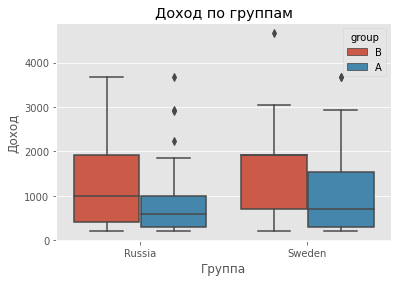

In [183]:
# С разбивкой по странам
sns.boxplot(x='country', y='revenue', hue='group', data=df_paying_user)
plt.title('Доход по группам')
plt.xlabel('Группа')
plt.ylabel('Доход')

Исходя из представленных графиков Общий доход в России в тестовой группе имеет выреженный эффект.
Возможные выбросы имеются в контрольной группе в России(что не влияет на очевидное превосходство дохода тестовой группы. Также , из-за отсутствия исторических данных, мы не можем оценить можно ли считать эти данные выбросами или нормальными значениями), а также во всех группах в Швеции.
Медианное значение дохода в тестовой группы в России больше,чем в контрольной

#### Рассчитаем медианное значение дохода в группах отдельно для стран

##### Для России

In [185]:
# считаем медианное значение дохода в контрольной группе
a_Russia_mean = df_paying_user.query("country == 'Russia' & group == 'A'").revenue.median()
print('Медиана дохода в контрольной группе А:', round(a_Russia_mean, 2))

Медиана дохода в контрольной группе А: 590.0


In [186]:
# считаем медианное значение дохода в тестовой группе
b_Russia_mean = df_paying_user.query("country == 'Russia' & group == 'B' & revenue > 3000").revenue.median()
print('Медиана дохода в тестовой группе B:', round(b_Russia_mean, 2))

Медиана дохода в тестовой группе B: 3670.0


In [187]:
# размах значений в контрольной группе
np.percentile(df_paying_user.query("country == 'Russia' & group == 'A'").revenue, [0,100])

array([ 208., 3669.])

In [188]:
# размах значений в тестовой группе
np.percentile(df_paying_user.query("country == 'Russia' & group == 'B'").revenue, [0,100])

array([ 207., 3671.])

Размах max и min значений в обоих группах схож, а медиана дохода в тестовой группе в 2 раза выше, чем в контрольной.

##### Для Швеции

In [189]:
# считаем медианное значение дохода в контрольной группе
a_Sweden_mean = df_paying_user.query("country == 'Sweden' & group == 'A'").revenue.median()
print('Медиана дохода в контрольной группе А:', round(a_Sweden_mean, 2))

Медиана дохода в контрольной группе А: 698.0


In [190]:
# считаем медианное значение дохода в тестовой группе
b_Sweden_mean = df_paying_user.query("country == 'Sweden' & group == 'B'").revenue.median()
print('Медиана дохода в тестовой группе B:', round(b_Sweden_mean, 2))

Медиана дохода в тестовой группе B: 1908.0


In [191]:
# размах значений в контрольной группе
np.percentile(df_paying_user.query("country == 'Sweden' & group == 'A'").revenue, [0,100])

array([ 208., 3671.])

In [192]:
# размах значений в тестовой группе
np.percentile(df_paying_user.query("country == 'Sweden' & group == 'B'").revenue, [0,100])

array([ 208., 4660.])

Размах значений в тестовой группе больше, чем в контрольной. А медиана дохода в 3 раза в тестовой группе превысила значение, чем в контрольной. Но данный эффект возможно обусловлен несбалансированной выборкой между группами в Швеции. И возможно, если бы непонятность с пользователями на android, которые в тестовой группе показали доход гораздо ниже, чем в контрольной в сравнении с пользователями на ios, то общий доход был бы еще выше.

In [193]:
# Кол-во платящих польз-лей в Швеции в контрольной группе
df_paying_user.query("country == 'Sweden' and group == 'A'").shape[0]

35

In [194]:
# Кол-во платящих польз-лей в Швеции в тестовой группе
df_paying_user.query("country == 'Sweden' and group == 'B'").shape[0]

117

In [195]:
# Кол-во платящих польз-лей в России в контрольной группе
df_paying_user.query("country == 'Russia' and group == 'A'").shape[0]

43

In [196]:
# Кол-во платящих польз-лей в России в тестовой группе
df_paying_user.query("country == 'Russia' and group == 'B'").shape[0]

197

### Т.к. выборки небольшие проведем анализ на нормальность с помощью теста Шапиро-Уилка.
Н0 - данные взяты из нормального распределения

#### Для всех стран

In [197]:
# Контрольная группа
stats.shapiro(df_paying_user.query("group == 'A'").revenue)[1]

1.5417730980793465e-10

In [198]:
# Тестовая группа
stats.shapiro(df_paying_user.query("group == 'B'").revenue)[1]

1.665431681028873e-16

In [199]:
# Уменьшим размер выборки в тестовой группе до соответсвия с контрольной 
B_sample = df_paying_user.query("group == 'B'").revenue.sample(df_paying_user.query("group == 'A'").shape[0], random_state=17)

In [200]:
# Тест с ограниченной выборкой для тестовой группы
stats.shapiro(B_sample)[1]

3.357002498205475e-08

#### Для России

In [201]:
stats.shapiro(df_paying_user.query("country == 'Russia' and group == 'A'").revenue)[1]

7.295019344155662e-08

In [202]:
stats.shapiro(df_paying_user.query("country == 'Russia' and group == 'B'").revenue)[1]

1.0906919898495682e-12

#### Для Швеции

In [203]:
stats.shapiro(df_paying_user.query("country == 'Sweden' and group == 'A'").revenue)[1]

5.708227490686113e-06

In [204]:
stats.shapiro(df_paying_user.query("country == 'Sweden' and group == 'B'").revenue)[1]

1.2456938813798502e-09

#### Для всех тестов p-value ниже уровня 0,01. Поэтому отклоняем нулевую гипотезу. 
Гистограммы дистплот и тест Шапиро-Уилка указывают на то, что выборки имеют ненормальное распределение.
Учтем это в дальнейшем при оценке стат.значимости результатов.
А пока посчитаем основные метрика продукта для оценки эффекта от проведения a/b тестирования.



## МЕТРИКИ ПРОДУКТА
Какие данные мы имеем:
- id пользователя
- в какой группе он находится(тестовая-А или контрольная-В)
- страна пользователя
- платформа с которой заходил пользователь в приложение
- пол
- доход

Временных данных никаких нет, поэтому метрики, на которые стоит опираться в данном случает, по моему мнению могут быть такими:

* Конверсия(CR, conversion rate) = (Кол-во польз-лей, совершивших целевое дейтсвие)/(Общее число пользователей)
* Cредний доход от пользователя за период(ARPU, Average Revenue Per User) = (Общий доход)/(Кол-во пользователей)
* Cредний доход от платящего пользователя за период(ARPPU, Average Revenue Per Paying User) = (Общий доход)/(Кол-во платящих пользователей)

### CR, conversion rate = (Кол-во польз-лей, совершивших целевое дейтсвие)/(Общее число пользователей)

#### Общая

In [205]:
# Кол-во платащих пользователей в контрольной группе
A_paying = df_paying_user.query("group == 'A'").user_id.count()
A_paying

78

In [206]:
# Кол-во всех пользователей в контрольной группе
A_full = df_full.query("group == 'A'").user_id.count()
A_full

1538

In [207]:
# Кол-во платащих пользователей в тестовой группе
B_paying = df_paying_user.query("group == 'B'").user_id.count()
B_paying

314

In [208]:
# Кол-во всех пользователей в тестовой группе
B_full = df_full.query("group == 'B'").user_id.count()
B_full

6803

In [209]:
CR_A_all = (A_paying/A_full)*100
print('Конверсия в контрольной группе: ', round(CR_A_all, 2), '%', sep='')

Конверсия в контрольной группе: 5.07%


In [210]:
CR_B_all = (B_paying/B_full)*100
print('Конверсия в тестовой группе: ', round(CR_B_all, 2), '%', sep='')

Конверсия в тестовой группе: 4.62%


#### Для России

In [211]:
CR_A_Russia = (df_paying_user.query("country == 'Russia' and group == 'A'").user_id.count()/df_full.query("country == 'Russia' and group == 'A'").user_id.count())*100
print('Конверсия в контрольной группе в России: ', round(CR_A_Russia, 2), '%', sep='')

Конверсия в контрольной группе в России: 4.7%


In [212]:
CR_B_Russia = (df_paying_user.query("country == 'Russia' and group == 'B'").user_id.count()/df_full.query("country == 'Russia' and group == 'B'").user_id.count())*100
print('Конверсия в тестовой группе в России: ', round(CR_B_Russia, 2), '%', sep='')

Конверсия в тестовой группе в России: 4.39%


#### Для Швеции

In [213]:
CR_A_Sweden = (df_paying_user.query("country == 'Sweden' and group == 'A'").user_id.count()/df_full.query("country == 'Sweden' and group == 'A'").user_id.count())*100
print('Конверсия в контрольной группе в Швеции: ', round(CR_A_Sweden, 2), '%', sep='')

Конверсия в контрольной группе в Швеции: 5.62%


In [214]:
CR_B_Sweden = (df_paying_user.query("country == 'Sweden' and group == 'B'").user_id.count()/df_full.query("country == 'Sweden' and group == 'B'").user_id.count())*100
print('Конверсия в тестовой группе в Швеции: ', round(CR_B_Sweden, 2), '%', sep='')

Конверсия в тестовой группе в Швеции: 5.06%


Конверсия, в совокупности по всем странам и с разделением, для тестовой группы уменьшилась. Данную метрику (как основную) не рекомендуется использовать для окончательного принятия решения о эффективности a/b тестирования, т.к. при анализе данных выяснилось много вопросов о работе приложения на разных платформах.
Оценим другие метрики.

### ARPU, Average Revenue Per User) = (Общий доход)/(Кол-во пользователей)

#### Для всех стран в совокупности

In [215]:
ARPU_A_all = (df_full.query("group == 'A'").revenue.sum())/A_full
print('Средний доход от пользователя в контрольной группе: ', round(ARPU_A_all, 2), '$', sep='')

Средний доход от пользователя в контрольной группе: 47.85$


In [216]:
ARPU_B_all = (df_full.query("group == 'B'").revenue.sum())/B_full
print('Средний доход от пользователя в тестовой группе: ', round(ARPU_B_all, 2), '$', sep='')

Средний доход от пользователя в тестовой группе: 58.52$


#### Для России

In [217]:
ARPU_A_Russia = (df_full.query("country == 'Russia' and group == 'A'").revenue.sum())/df_full.query("country == 'Russia' and group == 'A'").user_id.count()
print('Средний доход от пользователя в контрольной группе в России: ', round(ARPU_A_Russia, 2), '$', sep='')

Средний доход от пользователя в контрольной группе в России: 38.7$


In [218]:
ARPU_B_Russia = (df_full.query("country == 'Russia' and group == 'B'").revenue.sum())/df_full.query("country == 'Russia' and group == 'B'").user_id.count()
print('Средний доход от пользователя в тестовой группе в России: ', round(ARPU_B_Russia, 2), '$', sep='')

Средний доход от пользователя в тестовой группе в России: 53.3$


#### Для Швеции

In [221]:
ARPU_A_Sweden = (df_full.query("country == 'Sweden' and group == 'A'").revenue.sum())/df_full.query("country == 'Sweden' and group == 'A'").user_id.count()
print('Средний доход от пользователя в контрольной группе в Швеции: ', round(ARPU_A_Sweden, 2), '$', sep='')

Средний доход от пользователя в контрольной группе в Швеции: 61.3$


In [222]:
ARPU_B_Sweden = (df_full.query("country == 'Sweden' and group == 'B'").revenue.sum())/df_full.query("country == 'Sweden' and group == 'B'").user_id.count()
print('Средний доход от пользователя в тестовой группе в Швеции: ', round(ARPU_B_Sweden, 2), '$', sep='')

Средний доход от пользователя в тестовой группе в Швеции: 68.66$


#### Во всех тестовых группах показатель ARPU явно больше, чем в контрольной. Особено выражено для России.

### ARPPU, Average Revenue Per Paying User) = (Общий доход)/(Кол-во платящих пользователей)

#### Для всех стран в совокупности

In [223]:
ARPPU_A_all = (df_full.query("group == 'A'").revenue.sum())/A_paying
print('Средний доход от платящего пользователя в контрольной группе: ', round(ARPPU_A_all, 2), '$', sep='')

Средний доход от платящего пользователя в контрольной группе: 943.56$


In [224]:
ARPPU_B_all = (df_full.query("group == 'B'").revenue.sum())/B_paying
print('Средний доход от платящего пользователя в тестовой группе: ', round(ARPPU_B_all, 2), '$', sep='')

Средний доход от платящего пользователя в тестовой группе: 1267.88$


#### Для России

In [225]:
ARPPU_A_Russia = (df_full.query("country == 'Russia' and group == 'A'").revenue.sum())/df_paying_user.query("country == 'Russia' and group == 'A'").user_id.count()
print('Средний доход от платящего пользователя в контрольной группе в России: ', round(ARPPU_A_Russia, 2), '$', sep='')

Средний доход от платящего пользователя в контрольной группе в России: 823.42$


In [226]:
ARPPU_B_Russia = (df_full.query("country == 'Russia' and group == 'B'").revenue.sum())/df_paying_user.query("country == 'Russia' and group == 'B'").user_id.count()
print('Средний доход от платящего пользователя в тестовой группе в России: ', round(ARPPU_B_all, 2), '$', sep='')

Средний доход от платящего пользователя в тестовой группе в России: 1267.88$


#### Для Швеции

In [227]:
ARPPU_A_Sweden = (df_full.query("country == 'Sweden' and group == 'A'").revenue.sum())/df_paying_user.query("country == 'Sweden' and group == 'A'").user_id.count()
print('Средний доход от платящего пользователя в контрольной группе в Швеции: ', round(ARPPU_A_Sweden, 2), '$', sep='')

Средний доход от платящего пользователя в контрольной группе в Швеции: 1091.17$


In [228]:
ARPPU_B_Sweden = (df_full.query("country == 'Sweden' and group == 'B'").revenue.sum())/df_paying_user.query("country == 'Sweden' and group == 'B'").user_id.count()
print('Средний доход от платящего пользователя в тестовой группе в Швеции: ', round(ARPPU_B_Sweden, 2), '$', sep='')

Средний доход от платящего пользователя в тестовой группе в Швеции: 1356.16$


#### Во всех тестовых группах показатель ARPPU явно больше, чем в контрольной. 

## Оценка статистической значимости результатов A/B тестирования

#### Для оценки стат.значимости результатов воспользуемся бутстрапом(проверяем гипотезу о равенстве медиант, т.к. имеются Возможные выбросы). 
#### Критерий Манна-Уитни, как и любой статистический оценщик, не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект).

### BOOTSTRAP
H0 - стат. различия отсутствуют

In [111]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

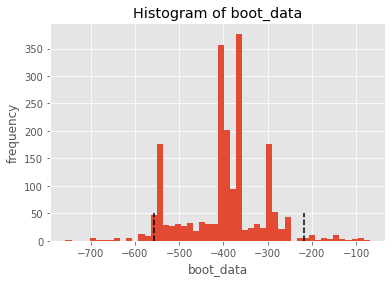

In [112]:
bootstrap_median = get_bootstrap(df_paying_user.query("group == 'A'").revenue, 
                                 df_paying_user.query("group == 'B'").revenue, 
                                 boot_it=2000) 

In [183]:
# Вывод уровня значимости для метода Bootstrap по медианным значения
bootstrap_median["p_value"]

1.3935326822911155e-05

In [184]:
# Вывод доверительного интервала для метода Bootstrap по медианным значения
bootstrap_median["ci"]

,0
0.025,-566.0125
0.975,-204.9875


#### p-value значительно ниже 0,05 и в доверительный интервал не входит 0, поэтому отклоняем нулевую гипотезу и принимаем альтернативную, соответственно различия стат. значимые.

Попробуем запустить bootstrap для сбалансированных выборок(применим сэмплирование в тестовой группе, чтобы уровнять выборки)

In [204]:
# Проверим число пользователей, совершивших целевое дейтсвие, в контрольной группе
df_paying_user.query("group == 'A'").user_id.count()

78

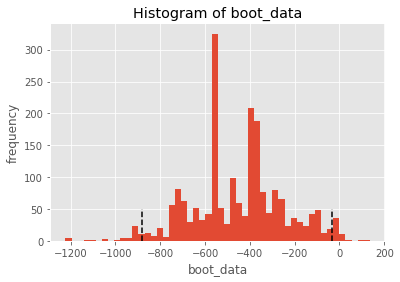

In [214]:
bootstrap_median_2 = get_bootstrap(df_paying_user.query("group == 'A'").revenue, 
                                 df_paying_user.query("group == 'B'").revenue.sample(78, replace = False, random_state=17), 
                                 boot_it=2000) 

In [215]:
# Вывод уровня значимости для метода Bootstrap по медианным значения
bootstrap_median_2["p_value"]

0.028739795503631982

In [216]:
# Вывод доверительного интервала для метода Bootstrap по медианным значения
bootstrap_median_2["ci"]

,0
0.025,-879.5125
0.975,-34.3125


#### Уменьшение размера выборки в тестовой группе показало такие же результаты как и с несбалансированными (исходными) выборками. 

#### Bootstrap для пользователей из России

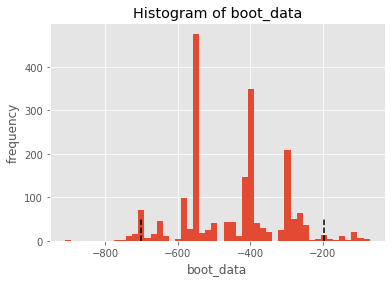

In [218]:
bootstrap_median_Russia = get_bootstrap(df_paying_user.query("country == 'Russia' and group == 'A'").revenue, 
                                 df_paying_user.query("country == 'Russia' and group == 'B'").revenue, 
                                 boot_it=2000) 

In [219]:
# Вывод уровня значимости для метода Bootstrap по медианным значения
bootstrap_median_Russia["p_value"]

0.0008096911352104257

In [220]:
# Вывод доверительного интервала для метода Bootstrap по медианным значения
bootstrap_median_Russia["ci"]

,0
0.025,-700.0
0.975,-197.0


#### Bootstrap для пользователей из Швеции

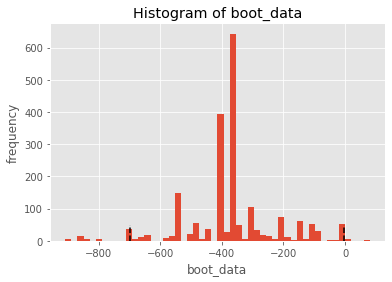

In [119]:
bootstrap_median_Sweden = get_bootstrap(df_paying_user.query("country == 'Sweden' and group == 'A'").revenue, 
                                 df_paying_user.query("country == 'Sweden' and group == 'B'").revenue, 
                                 boot_it=2000) 

In [120]:
bootstrap_median_Sweden["p_value"]

0.012397322568698785

In [121]:
bootstrap_median_Sweden["ci"]

,0
0.025,-700.0
0.975,-3.0


#### О чем нам говорят результаты bootstrap?
Медианное значение дохода с новым дизайном в тестовой группе выше, чем в контрольной, p-value<0.05.
Мы достаточно можем быть уверены в том, что наблюдаемый эффект от изменения приложения, а не просто нам повезло.

### Тест Манна-Уитни о равенстве распределений.
Н0 - распределение, лежащее в основе выборки тестовой , совпадает с распределением, лежащим в основе выборки контрольной

In [230]:
# Тест с несбалансированными выборками
mannwhitneyu(df_paying_user.query("group == 'A'").revenue, 
                   df_paying_user.query("group == 'B'").revenue, use_continuity=True)


MannwhitneyuResult(statistic=8961.0, pvalue=0.00023939080114586078)

In [231]:
# Тест с балансированными выборками
mannwhitneyu(df_paying_user.query("group == 'A'").revenue, 
                   df_paying_user.query("group == 'B'").revenue.sample(78, replace = False, random_state=17), use_continuity=True)

MannwhitneyuResult(statistic=2183.0, pvalue=0.002314386566950298)

In [234]:
# Только для России
mannwhitneyu(df_paying_user.query("country == 'Russia' and group == 'A'").revenue, 
                   df_paying_user.query("country == 'Russia' and group == 'B'").revenue, use_continuity=True)


MannwhitneyuResult(statistic=2925.5, pvalue=0.0014699816493472517)

In [235]:
# Только для Швеции
mannwhitneyu(df_paying_user.query("country == 'Sweden' and group == 'A'").revenue, 
                   df_paying_user.query("country == 'Sweden' and group == 'B'").revenue, use_continuity=True)


MannwhitneyuResult(statistic=1577.5, pvalue=0.03958280081671394)

#### О чем нам говорят результаты теста Манна-Уитни?
p-value<0.05 для всех вариантов. Нулевую гипотезу отклоняем, принимаем алтернативную: различия есть.
Мы достаточно можем быть уверены в том, что наблюдаемый эффект от изменения приложения, а не просто нам повезло.

### Рассчитаем T-критерий для средних значений двух независимых выборок.
Н0 : средние значения выборок равны

#### Общая

In [37]:
a = df_paying_user.query("group == 'A'").revenue
b = df_paying_user.query("group == 'B'").revenue

In [44]:
# Без разделения по странам
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-3.134033935298925, pvalue=0.0018546337642145053)

#### Для России. Т.к. дисперсии выборок неравны для России, то используем t-критерий Уэлча.

In [46]:
a_Russia = df_paying_user.query("country == 'Russia' and group == 'A'").revenue
b_Russia = df_paying_user.query("country == 'Russia' and group == 'B'").revenue

In [47]:
stats.ttest_ind(a_Russia, b_Russia, equal_var = False)

Ttest_indResult(statistic=-2.9617155474816657, pvalue=0.004360162869857023)

#### Для Швеции

In [48]:
a_Sweden = df_paying_user.query("country == 'Sweden' and group == 'A'").revenue
b_Sweden = df_paying_user.query("country == 'Sweden' and group == 'B'").revenue

In [49]:
stats.ttest_ind(a_Sweden, b_Sweden)

Ttest_indResult(statistic=-1.5696225706704943, pvalue=0.11861002409823568)

Для России мы не можем отклонить нулевую гипотезу и считаем результат стат. значимым. А в Швеции результат не стат. значим.

# Выводы: 
Из 74576 уникальных пользователей, участвующих в тестировании (из них в тестовой группе - 59883, контрольной - 14693), кол-во пользователей, посетивших приложение составило 8341, а пользователей совершивших целевое действие (в нашем случае оплата моделей шаблонов) 541.

При соединении датафреймов, заметила, что данные о некоторых пользователях отсутствуют. Они заплатили, но информации о них нет.
Рассмотрим ниже.

In [142]:
df_no_information = df.merge(purchases, on="user_id", how="right")

In [144]:
# Кол-во пользователй, о которых отсутвует информация
df_no_information.isna().sum()

user_id       0
group       149
country     149
platform    149
sex         149
revenue       0
dtype: int64

О 149 пользователях информация отсутсвует. Требует дополнительной проработки этого вопроса, т.к. это может повлиять на сравнении основных метрик между группами тестовой и контрольной.

Что касаемо пользователей с полной информацией.

В контрольной группе число покупателей составило 78 человек, в тестовой 314.Выборки имеют сильный дисбаланс. Так, в тестовой группе людей в 4 раза больше.

При анализе данных о разбивке пользователей выяснилось, что соотношение пользователей в группах А и В в Швеции имеет сильно выраженный дисбаланс в сравнении с Россией(в России отношение А/В: 43/197, в Швеции 35/117). Дисбаланс обусловлен неравномерным распределением пользователей по платформам. Пользователей на android в тестовой группе было гораздо больше, чем на ios. Однако, медианное значение дохода на androide в тестовой группе в Швеции значительно ниже, чем в контрольной. Т.е. с выкатыванием новой фичи приложения с колекцией шаблонов на пользователей в Швеции с платформой android доход значительно ниже, чем в контрольной группе на ios. Вопрос в коректной работе новой версии приложения на платформе android в Швеции.

Также, в России наблюдался разброс в отношении пола пользователей. Женщин в тестовой группе значительно больше, чем мужчин.

Я разделила оценку тестирования по странам. 

##### Тест Левена на равность дисперсий выборок:
В России мы отклоняем нулевую гипотезу(дисперсии выборок не равны, возможно обусловлено выбросами). В Швеции мы не можем отклонить нулевую гипотезу(дисперсии выборок равны).

##### Тест Шапиро-Уилка, гистограммы и дистплот указывают на то, что выборки имеют ненормальное распределение.
Что касаяемо "возможных" выбросов? Это мы оценить не можем, т.к. нет исторических данных. Так, для России тестовой группы это не важно, потому что явных возможных выбросов в значениях нет.


Основные метрики.

#### CR:
Конверсия упала и для России и для Швеции:
 - В России упала 4,7% до 4,39%
 - В Швеции с 5,62% до 5,06%

#### ARPU:

 - Для России рост с 38,7  до 53,3 (рост на 37,7%)
 - Для Швеции рост с 61,3  до 68,6 (рост на 12%)

#### ARPPU:

 - Для России рост с 823,42  до 1267,88 (рост на 54%)
 - Для Швеции рост с 1091,17  до 1356,16 (рост на 24,3%)


#### Bootstrap и тест Манна-Уитни показали, что мы можем быть достаточно уверены в том, что наблюдаемый эффект от изменения приложения, а не просто нам повезло.
Однако, t-test показал отсутствие стат.значимой разности средних в тестовой и контрольной группах для Швеции.

Есть еще ряд замечаний к данным:
1) нет данных о среднем чеке пользователя, кол-ве покупок. Так,имеем данные только об уникальных пользователях и какой-то доход, а из чего он складывается непонятно
2) нет никаких временных параметров. Ни даты оплат ни времени. В итоге, неизвестны временные рамки тестирования(1 день или 3 месяца) и оценить являются ли выбросы выбросами.

### Резюмируя все вышесказанное, эффект от новой модели оплаты коллекций шаблонов ярко выражен для пользователей из России, что подтвердили стат. тесты и мы может сказать, что результаты стат.значимы. Для Швеции есть много "но" и t-test показал отсутсвие стат.значимости в результатах. Поэтому, по результатам A/B тестирования новую модель приложения можно выкатывать только на пользователей из России. Дисперсия выборок для России не одинаковая, однако факт увеличения дохода в тестовой группе достаточно очевиден и t-test (применяя критерий Уэлча) показал, что различия стат.значимы, а не просто нам повезло. Для Швеции необходимо произвести дополнительный анализ работоспособности новой версии приложения на разных платформах. Если выкатывать новую версию на Швецию, то можно получить ложноположительный эффект. 
ИТОГ: выкатываем новую версию для России.

# Задание 2

In [43]:
# Сохраним датафрейм с объединенными данными в один для удобной работы в tableau
df_full.to_csv('testing.csv')

#### Ссылка на дашборд
https://public.tableau.com/app/profile/olga.demchenko/viz/FinalProjectvar_4byOlgaDemchenko/Dashboard1?publish=yes

Заполненный dashbord canvas находится в файле 
Dashboard_Canvas_Final_Project_var4.pptx